# Natural Language Processing with Disasters
----------------------------------------------------------------------------

**Author**: Rafael Oliva

## Introduction
----------------------------------------------------------------------------

Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

But, it’s not always clear whether a person’s words are actually announcing a disaster. 

In this competition, you’re challenged to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t. You’ll have access to a dataset of 10,000 tweets that were hand classified. 

In this project we will be using Text Classification with LSTM.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
#nltk.download('stopwords')
#nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
stop=set(stopwords.words('english'))
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow import keras
from collections import defaultdict

import warnings
warnings.filterwarnings('ignore')


In [2]:
import os

cwd = os.getcwd()  # Get the current working directory (cwd)
files = os.listdir(cwd)  # Get all the files in that directory
print("Files in %r: %s" % (cwd, files))

Files in 'C:\\Users\\darkk\\Documents\\DATA SCIENCE\\06 Natural Language Processing with Disaster Tweets': ['.ipynb_checkpoints', 'data', 'NLP_twitter.py', 'NLP_twitter_notebook.ipynb']


In [3]:
train = pd.read_csv("./data/train.csv")
train.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [4]:
test = pd.read_csv("./data/test.csv")
test.head(10)

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
5,12,NaN,NaN,We're shaking...It's an earthquake
6,21,NaN,NaN,They'd probably still show more life than Arse...
7,22,NaN,NaN,Hey! How are you?
8,27,NaN,NaN,What a nice hat?
9,29,NaN,NaN,Fuck off!


## Data Understanding
----------------------------------------------------------------------------

Before we continue with anything we will begim with Exploratory Data Analysis on the data set. This will help us understand what we are up against and how the data is behaving so we can construct a better model to decifer each tweet. 

So as a first step we will visualize the class distribution in our data set. There are only two classes in here; 0 and 1. 

0    4342
1    3271
Name: target, dtype: int64


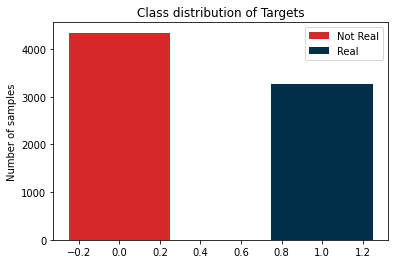

In [5]:
print(train.target.value_counts())

class_0 = train.target.value_counts()[0]
class_1 = train.target.value_counts()[1]
plt.bar(0, class_0, 0.5, label = 'Not Real', color = '#d62828')
plt.bar(1, class_1, 0.5, label = 'Real', color = '#003049')
plt.legend()
plt.ylabel('Number of samples')
plt.title('Class distribution of Targets')
plt.show()

We can see from the 'Class distribution of Targets' graph, there are more not real disaster tweets than there are real disasters tweets. 

Now, we will do a simple statistcs analysis at a character level, word level and sentence level.

We will start with the **character analysis in a tweet**

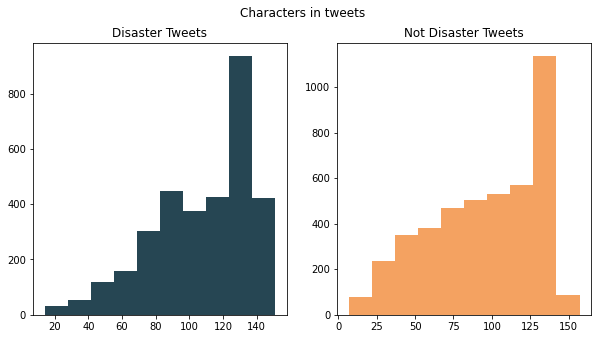

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,5))

tweet_len = train[train['target'] == 1]['text'].str.len()
ax1.hist(tweet_len, color = '#264653')
ax1.set_title('Disaster Tweets')

tweet_len = train[train['target'] == 0]['text'].str.len()
ax2.hist(tweet_len, color = '#f4a261')
ax2.set_title('Not Disaster Tweets')

fig.suptitle('Characters in tweets')
plt.show()


The distribution of both classes of tweets seems to be the same. From 120 to 140 characters in a single tweet seems to be the most common among both classes.

As the next step, we will analyses the amount of words in the tweets from our training data set.

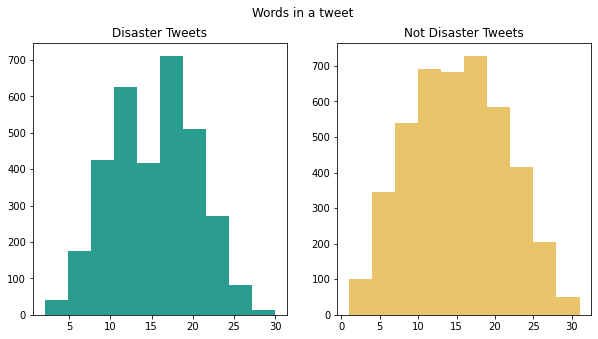

In [7]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,5))

tweet_len = train[train['target'] == 1]['text'].str.split().map(lambda word: len(word))
ax1.hist(tweet_len, color = '#2a9d8f')
ax1.set_title('Disaster Tweets')

tweet_len = train[train['target'] == 0]['text'].str.split().map(lambda word: len(word))
ax2.hist(tweet_len, color = '#e9c46a')
ax2.set_title('Not Disaster Tweets')

fig.suptitle('Words in a tweet')
plt.show()


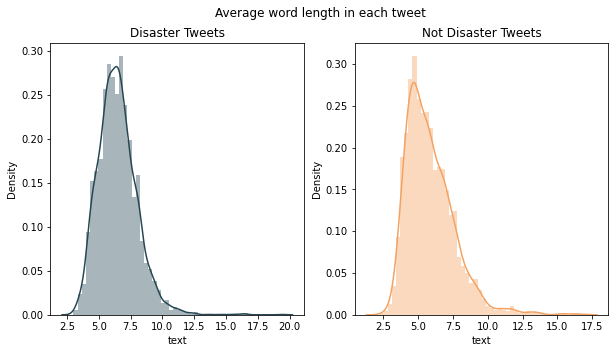

In [8]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (10,5))
word = train[train['target'] == 1]['text'].str.split().apply(lambda x: [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)), ax = ax1, color = '#264653')
ax1.set_title('Disaster Tweets')

word = train[train['target'] == 0]['text'].str.split().apply(lambda x: [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)), ax = ax2, color = '#f4a261')
ax2.set_title('Not Disaster Tweets')

fig.suptitle('Average word length in each tweet')
plt.show()


The average word length in each tweet depending of the class is represented by the graph above. Here we can visualize that for the tweets that are disaster related, have an average of about 7 word per tweet. While the tweets that are not disaster related, have about 5.5 words in average per tweet. 

As the next step, we will analyze the amount of stop words that there are within each class of tweet in our target label. 

In [9]:
def create_corpus(target):
    corpus=[]
    
    for x in train[train['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

In [10]:
corpus=create_corpus(0)

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
        
top0=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 

In [11]:
corpus=create_corpus(1)

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1

top1=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 


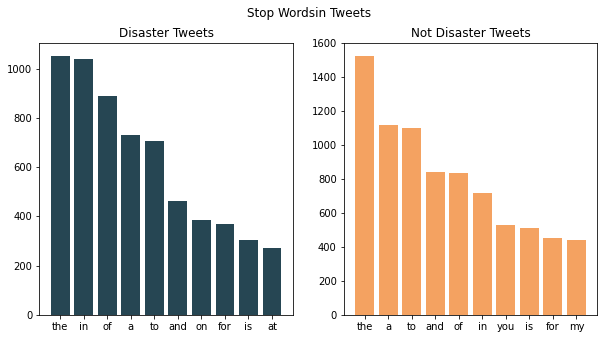

In [12]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (10,5))

x, y = zip(*top1)
ax1.bar(x,y, color = '#264653')
ax1.set_title('Disaster Tweets')

x, y = zip(*top0)
ax2.bar(x,y, color = '#f4a261')
ax2.set_title('Not Disaster Tweets')

fig.suptitle('Stop Wordsin Tweets')
plt.show()

We can see that in both cases the stop word "the" dominates in the data set. While in the Disaster tweets class, the "in" stop word is a clsoe second. But in the tweets that are not disaster related, the "a" is a far second. 

## Data Preparetion
----------------------------------------------------------------------------

In this phase of the project we will make each tweet readable and more understandable. Where we will remove the usernames of the text make everything lower case as well we will remove puntuations from each tweet together with removing every stop word and lemmatize the words that we are looking to make our keywords.

Firstly we will make the every text of the data set a lower case. So everything that we do at this point has the same range of values. If we leave the capital letters it will mess with the values and make cases for us to consider.

In [13]:
train['new_text'] = train['text'].apply(lambda text:text.lower())
train.head(5)

,id,keyword,location,text,target,new_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this #earthquake m...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask. canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,all residents asked to 'shelter in place' are ...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,"13,000 people receive #wildfires evacuation or..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby #alaska as ...


Now that our text is in a shorter value range (only lower case) we will start the process of "Lemmatization".

Lemmatization is the process of grouping together the different inflected forms of a word so they can be analyzed as a single item (easier to analyze). This does morphological analysis of the each of the words so they are simpler to classify.An example can be:

- rocks: rock
- loving: love
- better: good

This help us get a better context for each of the tweets and make our computer understand what's the reason of each tweet (disaster related tweet or non-related disaster).

In [14]:
lemmatizer = WordNetLemmatizer()
train['lemm_text'] = train['new_text'].apply(lambda text:lemmatizer.lemmatize(text))
train.head(10)

,id,keyword,location,text,target,new_text,lemm_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this #earthquake m...,our deeds are the reason of this #earthquake m...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask. canada,forest fire near la ronge sask. canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,all residents asked to 'shelter in place' are ...,all residents asked to 'shelter in place' are ...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,"13,000 people receive #wildfires evacuation or...","13,000 people receive #wildfires evacuation or..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby #alaska as ...,just got sent this photo from ruby #alaska as ...
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1,#rockyfire update => california hwy. 20 closed...,#rockyfire update => california hwy. 20 closed...
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1,#flood #disaster heavy rain causes flash flood...,#flood #disaster heavy rain causes flash flood...
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1,i'm on top of the hill and i can see a fire in...,i'm on top of the hill and i can see a fire in...
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1,there's an emergency evacuation happening now ...,there's an emergency evacuation happening now ...
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1,i'm afraid that the tornado is coming to our a...,i'm afraid that the tornado is coming to our a...


For the following step after we have already lemmatize our training dataset. We will remove the stop words of the tweets.

Stop words are frequently used words that carry very little meaning. This words are so common that they are usually ignored for typical tokenizer.

By default NLTK already includes a list of 40 stop words.